### 1. import dataset and load sample

In [108]:
from datasets import load_dataset

dataset = load_dataset("bavard/personachat_truecased", "sample")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 14
    })
    validation: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 15
    })
})


In [109]:
print(dataset["train"][0])
    

{'personality': ['I like to remodel homes.', 'I like to go hunting.', 'I like to shoot a bow.', 'My favorite holiday is halloween.'], 'candidates': ['My mom was single with 3 boys, so we never left the projects.', 'I try to wear all black every day. It makes me feel comfortable.', 'Well nursing stresses you out so I wish luck with sister.', 'Yeah just want to pick up Nba nfl getting old.', 'I really like Celine Dion. What about you?', 'No. I live near farms.', "I wish I had a daughter, I'm a boy mom. They're beautiful boys though still lucky.", 'Yeah when I get bored I play gone with the wind my favorite movie.', "Hi how are you? I'm eating dinner with my hubby and 2 kids.", 'Were you married to your high school sweetheart? I was.', 'That is great to hear! Are you a competitive rider?', "Hi, I'm doing ok. I'm a banker. How about you?", "I'm 5 years old.", 'Hi there. How are you today?', 'I totally understand how stressful that can be.', 'Yeah sometimes you do not know what you are actu

### 2. Define history conversation, response, and persona

In [110]:
#select conversation with certain id
conv_id = 6
dataset = load_dataset("bavard/personachat_truecased", "full")
dialog = dataset.filter(lambda example:example['conv_id']== conv_id)


In [111]:
#select persona 
persona = dialog['train']['personality'][-1]
print("User Persona: ", persona, "\n")

#select the history conversation
history_convo = dialog['train']['history'][-1]
print("History Conversation: ", history_convo, "\n")

#select the response
usr_response = dialog['train']['candidates'][-1][-1]
print("Response: ",usr_response)


User Persona:  ['I have a boxer dog.', 'I like baths.', 'I like to listen to music.', 'My father lives in China.'] 

History Conversation:  ["Rock on, I'm listening to my favorite band guns and roses.", 'No kidding? I was just listening to the same thing while taking a bath.', 'Of course. I love to listen to rock.', 'Man my boxer just peed on the carpet!', "Well I'm into black everything. So at least it wouldn't show on my black carpet.", 'Ll. I love black too! Guess I was playing my music too loud.', "I've a black car, purse, wear all black.", 'Maybe I can borrow something as I am packing to visit my dad in China.', 'Wow, does he live there or work?', 'Live. Moved there about ten years ago for a computer tech job.', 'Have you visited him there before?', 'Once. You cannot even throw a gum wrapper or you can get arrested.', 'Sounds a bit scary. I ve never been.'] 

Response:  Well not too much crime there, but a lot of people.


### 3. Preprocess the text to make it suitable for prompting

In [125]:
#preprocess the persona
persona_processed = "User Persona: \n"
for sen in persona:
    persona_processed += sen + "\n"

#preprocess the history conversation
history_convo_processed = "Dialogue history: \n"

#concat all history except the last utter from the bot
for i in range(0,len(history_convo)-1,2):
    bot_uttr = "Bot: " + history_convo[i]
    user_uttr = "User: " + history_convo[i+1]
    full_uttr = bot_uttr + "\n" + user_uttr + "\n"
    history_convo_processed += full_uttr

#add the last utter from bot
history_convo_processed += "Bot: " + history_convo[-1] + "\n"

#concat prompt
prompt = persona_processed + "\n" + history_convo_processed + "\nResponse\nUser:"
print(prompt)

Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.

Response
User:


In [126]:
import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'sk-proj-zgpS1dH01GeQiQzhICjNT3BlbkFJq8oC1i8atPEckRUxahYK'
client = OpenAI()

response = client.chat.completions.create(
    model="gpt-3.5-turbo",  # Specify the model
    messages=[
        {"role": "system", "content": "According to the history conversation provided, pretend to speak like a human user and generate a response."},
        {"role": "user", "content": prompt}
    ],
    temperature=0,  # Adjust based on how creative you want the AI to be
    max_tokens=150, # Adjust based on how long you expect responses to be
)


In [127]:
import json
print(json.dumps(json.loads(response.model_dump_json()), indent=4))


{
    "id": "chatcmpl-9ikTtLOpcukHYtnHPaUuqlCtz9enM",
    "choices": [
        {
            "finish_reason": "stop",
            "index": 0,
            "logprobs": null,
            "message": {
                "content": "China is definitely a unique experience with its strict rules. It's important to be mindful of the cultural differences when visiting.",
                "role": "assistant",
                "function_call": null,
                "tool_calls": null
            }
        }
    ],
    "created": 1720452133,
    "model": "gpt-3.5-turbo-0125",
    "object": "chat.completion",
    "service_tier": null,
    "system_fingerprint": null,
    "usage": {
        "completion_tokens": 24,
        "prompt_tokens": 233,
        "total_tokens": 257
    }
}


In [128]:
response_chatgpt = response.choices[0].message.content

print(response_chatgpt)

print(usr_response)

China is definitely a unique experience with its strict rules. It's important to be mindful of the cultural differences when visiting.
Well not too much crime there, but a lot of people.


In [273]:
from datasets import load_dataset
import random

def get_random_conv_id(pool, num_conv):
    random_values = random.sample(pool, num_conv)

    for value in random_values:
        pool.remove(value)
    
    return random_values

def extract_format_data(dataset, conv_id):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)

    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"

    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "Response\nUser: " + usr_response + "\n"
    return [persona_processed, history_convo_processed, usr_response_processed]

def create_example(dataset, conv_id, implicit=False):
    materials = extract_format_data(dataset, conv_id)
    if implicit:
        return materials[1] + materials[2]
    else:
        return materials[0] + materials[1] + materials[2]
    return example

def create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=False):
    max_conv_id = dataset['train']['conv_id'][-1]
    pool = [num for num in range(1, max_conv_id + 1) if num != conv_id]
    random_conv_ids = get_random_conv_id(pool, few_shot_no)

    few_shot_examples = ""
    for index, conv_id in enumerate(random_conv_ids):
        few_shot_examples += f"Demo {index}:\n" + create_example(dataset, conv_id, implicit) + "\n"
    return few_shot_examples


def construct_prompt(dataset, conv_id, prompt_type, few_shot_no):
    max_conv_id = dataset['train']['conv_id'][-1]
    materials = extract_format_data(dataset, conv_id)
    system_prompt = ""
    user_prompt = ""
    few_shot_examples = ""

    if prompt_type == "context_only":
        user_prompt += materials[1] + "User:"

    if prompt_type == "task_prompt_context_implicit":
        system_prompt += "According to the history conversation provided, pretend to speak like a human user and generate a response."
        user_prompt += materials[1] + "User:"

    if prompt_type == "task_prompt_context_explicit":
        system_prompt += "According to the persona and history conversation provided, pretend to speak like a human user and generate a response."
        user_prompt += materials[0]+ materials[1] + "User:"

    if prompt_type == "few_shot_implicit":
        system_prompt += "According to the few shot demos provided, pretend to speak like User and generate a response matching the context."

        few_shot_examples = create_few_shot_examples(dataset, conv_id, few_shot_no,implicit=True)
        user_prompt += few_shot_examples + materials[1]+ "User:"

    return system_prompt, user_prompt, materials[2]

In [277]:
dataset = load_dataset("bavard/personachat_truecased", "full")
system_p, user_p, target_response = construct_prompt(dataset, 6, "few_shot_implicit", 1)

Filter: 100%|██████████| 7801/7801 [00:00<00:00, 52893.94 examples/s]


In [278]:
system_p

'According to the few shot demos provided, pretend to speak like User and generate a response matching the context.'

In [283]:
import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'sk-proj-zgpS1dH01GeQiQzhICjNT3BlbkFJq8oC1i8atPEckRUxahYK'
client = OpenAI()

def prompt_chatgpt(prompt_type, conv_id, few_shot_no=0):
    dataset = load_dataset("bavard/personachat_truecased", "full")
    system_prompt, user_prompt, target_response= construct_prompt(dataset, conv_id, prompt_type, few_shot_no)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",  # Specify the model
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.9,  # Adjust based on how creative you want the AI to be
        max_tokens=15, # Adjust based on how long you expect responses to be
    )
    return response.choices[0].message.content, user_prompt, target_response



In [284]:
response, user_prompt, target_repsonse= prompt_chatgpt("task_prompt_context_explicit", 6)

In [287]:
print(user_prompt)
print(response)
print(target_repsonse)

User Persona: 
I have a boxer dog.
I like baths.
I like to listen to music.
My father lives in China.
Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.
User:
It can be a bit intimidating at times, but overall it's a fascinating
Response
User: Well not too much crim

In [286]:
response

"It can be a bit intimidating at times, but overall it's a fascinating"

In [167]:
max_conv_id = len(dataset['train']['conv_id'])
print(max_conv_id)

131438


In [154]:
print(example)

User Persona: 
I have a boxer dog.
I like baths.
I like to listen to music.
My father lives in China.
Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.
Response:
User: Well not too much crime there, but a lot of people.


In [245]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [250]:
scores['rouge1'].fmeasure

0.7058823529411765

In [252]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def p_cover(persona, response):
    # Tokenize and remove stop words
    persona_tokens = [word for word in nltk.word_tokenize(persona.lower()) if word.isalnum() and word not in stop_words]
    response_tokens = [word for word in nltk.word_tokenize(response.lower()) if word.isalnum() and word not in stop_words]
    
    # Calculate TF-IDF for the persona terms
    vectorizer = TfidfVectorizer(vocabulary=set(persona_tokens))
    tfidf_matrix = vectorizer.fit_transform([response])
    
    # Extract the TF-IDF scores for the persona terms in the response
    tfidf_scores = tfidf_matrix.toarray()[0]
    
    # Calculate the P-Cover score
    p_cover_score = sum(tfidf_scores) / len(persona_tokens)
    
    return p_cover_score

# Example usage
persona = "I love playing basketball and enjoy watching movies."
response = "Basketball is my favorite sport. I also love watching movies in my free time."

p_cover_score = p_cover(persona, response)
print(f"P-Cover Score: {p_cover_score}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zarius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/zarius/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/share/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [258]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# implementation of P-Cover
def calculate_p_cover(persona, response):
    return 0

# implementation of BLEU-1, BLEU-2, BLEU-3, and BLEU-4
def calculate_bleu(reference_sentence, candidate_sentence):
    reference = [reference_sentence.split()]
    candidate = candidate_sentence.split()
    
    # Weights for BLEU-1, BLEU-2, BLEU-3, and BLEU-4
    weights = [
        (1.0, 0, 0, 0),        
        (0.5, 0.5, 0, 0),        
        (1.0 / 3, 1.0 / 3, 1.0 / 3, 0), 
        (0.25, 0.25, 0.25, 0.25) 
    ]
    
    # Use smoothing to handle cases with few n-grams
    smoothing_function = SmoothingFunction()
    scores = sentence_bleu(reference, candidate, weights, smoothing_function=smoothing_function.method1)
    return scores

# rouge1, rouge2, rougeL
def calculate_rouge(reference_sentence, candidate_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_sentence, candidate_sentence)
    return scores

def cosine_similarity_embeddings(sentence1, sentence2, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode([sentence1, sentence2])
    cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return cos_sim

def distinct_1(sentence):
    words = sentence.split()
    unique_unigrams = set(words)
    total_unigrams = len(words)
    if total_unigrams == 0:
        return 0.0
    distinct_1_score = len(unique_unigrams) / total_unigrams
    return distinct_1_score

def distinct_2(sentence):
    words = sentence.split()
    bigrams = list(nltk.bigrams(words))
    unique_bigrams = set(bigrams)
    total_bigrams = len(bigrams)
    if total_bigrams == 0:
        return 0.0
    distinct_2_score = len(unique_bigrams) / total_bigrams
    return distinct_2_score

def calculate_metrics(reference_sentence, candidate_sentence):
    bleu_score = calculate_bleu(reference_sentence, candidate_sentence)
    rouge_scores = calculate_rouge(reference_sentence, candidate_sentence)
    cosine_similarity = cosine_similarity_embeddings(reference_sentence, candidate_sentence)
    distinct_1_score = distinct_1(candidate_sentence)
    distinct_2_score = distinct_2(candidate_sentence)

    return {
        'BLEU-1': bleu_score[0],
        'BLEU-2': bleu_score[1],
        'BLEU-3': bleu_score[2],
        'BLEU-4': bleu_score[3],
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].fmeasure,
        'Cosine Similarity': cosine_similarity,
        'Distinct-1': distinct_1_score,
        'Distinct-2': distinct_2_score
    }


In [259]:
reference_sentence = "the cat is on the mat"
candidate_sentence = "the cat is on mat"
calculate_metrics(reference_sentence, candidate_sentence)

{'BLEU-1': 0.8187307530779819,
 'BLEU-2': 0.7090416310250969,
 'BLEU-3': 0.6498270293573523,
 'BLEU-4': 0.5789300674674098,
 'ROUGE-1': 0.9090909090909091,
 'ROUGE-2': 0.6666666666666665,
 'ROUGE-L': 0.9090909090909091,
 'Cosine Similarity': 0.9925266,
 'Distinct-1': 1.0,
 'Distinct-2': 1.0}

In [261]:
num_stories = 10
prompts = ["Once upon a time,"] * num_stories
stories = [""] * len(prompts)

In [262]:
stories

['', '', '', '', '', '', '', '', '', '']

In [272]:
from openai import OpenAI

client = OpenAI()

def prompt_chatgpt_batch(prompt_type, conv_ids, few_shot_no):
    dataset = load_dataset("bavard/personachat_truecased", "full")
    
    system_prompts = []
    user_prompts = []
    target_responses = []

    # Collect prompts for all conversation IDs
    for conv_id in conv_ids:
        system_prompt, user_prompt, target_response = construct_prompt(dataset, conv_id, prompt_type, few_shot_no)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt)
        target_responses.append(target_response)
    
    # Create batch messages for the API request
    messages = [{"role": "system", "content": system_prompt} for system_prompt in system_prompts]
    messages += [{"role": "user", "content": user_prompt} for user_prompt in user_prompts]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
        temperature=0.9,
        max_tokens=15,  # since persona-chat sets a maximum of 15 words per message
    )
    
    # Process responses and match to the original prompts
    responses = ["" for _ in conv_ids]
    for i, choice in enumerate(response.choices):
        index = i % len(conv_ids)
        responses[index] = choice.message.content
    
    # Combine responses with user prompts and target responses
    batch_responses = []
    for i in range(len(conv_ids)):
        batch_responses.append({
            "response": responses[i],
            "target_response": target_responses[i],
            "user_prompt": user_prompts[i]
        })
    
    return batch_responses

# Example usage:
conv_ids = [1]  # Replace with actual conversation IDs
prompt_type = "context_only"
few_shot_no = 0

batch_results = prompt_chatgpt_batch(prompt_type, conv_ids, few_shot_no)
for result in batch_results:
    print(f"User Prompt: {result['user_prompt']}")
    print(f"Response: {result['response']}")
    print(f"Target Response: {result['target_response']}")
    print()

User Prompt: Dialogue history: 
Bot: Hi, how are you doing today?
User: I am spending time with my 4 sisters what are you up to.
Bot: Wow, four sisters. Just watching game of thrones.
User: That is a good show I watch that while drinking iced tea.
Bot: I agree. What do you do for a living?
User: I'm a researcher I'm researching the fact that mermaids are real.
Bot: Interesting. I'm a website designer. Pretty much spend all my time on the computer.
User: That's cool my mom does the same thing.
Bot: That's awesome. I have always had a love for technology.
User: Tell me more about yourself.
Bot: I really enjoy free diving, how about you, have any hobbies?
User: I enjoy hanging with my mother she's my best friend.
Bot: That's nice. Moms are pretty cool too.
User:
Response: Yes, they are. I'm really lucky to have such a close relationship
Target Response: Response
User: I'm also fascinated with mermaids.




In [271]:
print(batch_results[0]['response'])

Dialogue history: 
Bot: Oh, mojitos are delicious. I


In [12]:
import random
from datasets import load_dataset

def get_random_conv_id(pool, num_conv):
    random_values = random.sample(pool, num_conv)

    for value in random_values:
        pool.remove(value)
    
    return random_values

def extract_format_data(dataset, conv_id):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)

    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]

    unprocessed = [persona, history_convo, usr_response]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"
    
    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "User: " + usr_response + "\n"

    processed = [persona_processed, history_convo_processed, usr_response_processed]
    return unprocessed, processed

# materials[0] is persona, materials[1] is history conversation, materials[2] is user response
def create_example(dataset, conv_id, implicit=False):
    _, materials = extract_format_data(dataset, conv_id)
    if implicit:
        return materials[1] + materials[2]
    else:
        return materials[0] + materials[1] + materials[2]
    

def create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=False):
    max_conv_id = dataset['train']['conv_id'][-1]
    pool = [num for num in range(1, max_conv_id + 1) if num != conv_id]
    random_conv_ids = get_random_conv_id(pool, few_shot_no)

    few_shot_examples = ""
    for index, conv_id in enumerate(random_conv_ids):
        few_shot_examples += f"Demo {index}:\n" + create_example(dataset, conv_id, implicit) + "\n"
    return few_shot_examples


def construct_prompt(dataset, conv_id, prompt_type, few_shot_no=1, print_output= False):
    max_conv_id = dataset['train']['conv_id'][-1]
    raw_materials, materials = extract_format_data(dataset, conv_id)
    raw_target_response = raw_materials[2]
    raw_persona_text = raw_materials[0]

    system_prompt = ""
    user_prompt = ""
    few_shot_examples = ""

    # only history dialogue
    if prompt_type == "context_only":
        user_prompt += materials[1] + "User:"

    # task prompt, history dialogue
    if prompt_type == "task_prompt_context_implicit":
        #version 1 Based on the previous conversation history, generate a response for the user that aligns with their profile and the current context of the discussion.
        system_prompt += "Considering the user's profile and the ongoing discussion's context as established in the previous dialogue history, craft a response within 15 words that is coherent, relevant, and tailored to the user's interests and style of communication."
        user_prompt += materials[1] + "User:"

    # task prompt, persona, and history dialogue
    if prompt_type == "task_prompt_context_explicit":
        system_prompt += "Given the user's profile as outlined in the provided persona information, and considering the context of the ongoing discussion from the previous dialogue history, craft a response that is specifically tailored to resonate with the user's explicit characteristics and maintains the continuity of the dialogue."
        user_prompt += materials[0]+ materials[1] + "User:"

    # few-shot demos, history dialogue
    if prompt_type == "few_shot_implicit":
        system_prompt += "Considering the various user profiles and styles depicted in the provided few-shot examples, and the ongoing discussion's context as established in the previous dialogue history, synthesize a coherent and relevant response. This response should be adaptable to the general preferences and communication styles observed in the examples, while seamlessly continuing the dialogue."

        #set the implicit flag to True to exclude persona in few-shot demos
        few_shot_examples = create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=True)
        user_prompt += few_shot_examples + materials[1]+ "User:"

    if print_output:
        print("### TASK PROMPT ###\n" + system_prompt)
        print("### USER PROMPT ###\n" + user_prompt)
    

    return system_prompt, user_prompt, raw_target_response, raw_persona_text


#context_only, task_prompt_context_implicit, task_prompt_context_explicit, few_shot_implicit
def test():
    dataset = load_dataset("bavard/personachat_truecased", "full")
    dataset
    result = construct_prompt(dataset, 1, "task_prompt_context_implicit",print_output=False)
    return result


/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
def test():
    name = "1"
    name2 = "2"

    return name, name2

result = test()

In [29]:
result[0]

'1'

In [73]:
conv_id = 6
dataset = load_dataset("bavard/personachat_truecased", "full")
#dialog = dataset['validation'].filter(lambda example:example['conv_id']== conv_id)


In [74]:
dataset

DatasetDict({
    train: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 131438
    })
    validation: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 7801
    })
})

In [1]:
from helper import read_json
data = read_json('experiment1')

In [2]:
from analyze import calculate_metrics
calculate_metrics(data[-1]['conv_id'], data[-1]['target_response'], data[-1]['generated_response'], data[-1]['persona_text'])

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


{'Conversation ID': 965,
 'BLEU-1': 0,
 'BLEU-2': 0,
 'BLEU-3': 0,
 'BLEU-4': 0,
 'ROUGE-1': 0.0,
 'ROUGE-2': 0.0,
 'ROUGE-L': 0,
 'Cosine Similarity': 0.20438892,
 'Distinct-1': 0.0,
 'Distinct-2': 0.0,
 'Token Overlap Ratio': 0.0,
 'Character Overlap Ratio': 0.0,
 'Inter Similarity': 0.04087778329849243,
 'Persona Coverage': 0,
 'Persona Recall': 0,
 'Persona Precision': 0,
 'Persona F1': 0}

In [2]:
metric_keys = data[0].keys()
print(metric_keys)

dict_keys(['Conversation ID', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity', 'Distinct-1', 'Distinct-2', 'Token Overlap Ratio', 'Character Overlap Ratio', 'Inter Similarity', 'Persona Coverage', 'Persona Recall', 'Persona Precision', 'Persona F1'])


In [7]:
def calculate_avg_metrics(data):
    avg_metrics = {
        'Conversation ID': 0,
        'BLEU-1': 0,
        'BLEU-2': 0,
        'BLEU-3': 0,
        'BLEU-4': 0,
        'ROUGE-1': 0,
        'ROUGE-2': 0,
        'ROUGE-L': 0,
        'Cosine Similarity': 0,
        'Distinct-1': 0,
        'Distinct-2': 0,
        'Token Overlap Ratio': 0,
        'Character Overlap Ratio': 0,
        'Inter Similarity': 0,
        'Persona Coverage': 0,
        'Persona Recall': 0,
        'Persona Precision': 0,
        'Persona F1': 0
    }
    for object in data:
        for key in object.keys():
            avg_metrics[key] += object[key]
    
    num_objects = len(data)
    for key in avg_metrics.keys():
        avg_metrics[key] /= num_objects 
        avg_metrics[key] = avg_metrics[key]*100
    return avg_metrics

avg_metrics = calculate_avg_metrics(data)
            


In [9]:
from analyze import print_avg_metrics
print_avg_metrics("experiment1_metrics")

{'Conversation ID': 499.5, 'BLEU-1': 0.1232292348429177, 'BLEU-2': 0.049328470627085876, 'BLEU-3': 0.0289745832318289, 'BLEU-4': 0.021344028967990904, 'ROUGE-1': 0.1561807770889836, 'ROUGE-2': 0.02986322457413851, 'ROUGE-L': 0.13987661453868921, 'Cosine Similarity': 0.30141694619180637, 'Distinct-1': 0.9554821806637072, 'Distinct-2': 0.9981878124227666, 'Token Overlap Ratio': 0.09041412052169583, 'Character Overlap Ratio': 0.5681395475299307, 'Inter Similarity': 0.2446152927250076, 'Persona Coverage': 0.0609735787729655, 'Persona Recall': 0.2592147019647016, 'Persona Precision': 0.12054429566079165, 'Persona F1': 0.1550908013546865}


In [58]:
dataset['validation']['history'][-1]

['Hi how are you?',
 'I am doing great on this crisp fall night.',
 'Do you like sports? I love tennis and play it for a living.',
 'Sports are ok but I love cooking shows and cooking.',
 'My husband is a doctor so I cook meals and freeze them to have on hand.',
 'That is a great idea I am single so I only make enough for one.',
 'Well enjoy being single, we are growing our family so free time is short.',
 'But it is tough cause I am vegan and my friends are not.',
 'Bummer, I take my dog for long walks to De stress, how about you?',
 'I like to go skydiving or ride a rollercoaster.',
 'When its raining or too cold we walk the stairs in our home, three stories!',
 'Wow first floor apt for me so no stairs.',
 'With a big family we need the room, plus the dog.',
 'How many children do u have.',
 'Three and one on the way. The dog is like a child too.']

In [11]:
import math
import gensim.downloader as api
import spacy
tokenizer = spacy.load('en_core_web_sm')

def tokenize(text):
    doc = tokenizer(text)
    # Filter out punctuation and stop words
    return [token.text.lower() for token in doc if token.is_alpha or token.is_digit]

def calculate_idf(tf_j):
    """Calculate the inverse document frequency (idf) for a given term frequency (tf_j)."""
    return 1 / (1 + math.log(1 + tf_j))

def calculate_tf(idx):
    """Calculate the term frequency (tf) using Zipf's Law for a Glove-twitter-100 index (idx)."""
    return 1e6 * (1 / (idx ** 1.07))

def calculate_persona_coverage(response, personas, glove_model):
    """
    Calculate Persona Coverage.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    glove_model: Pre-trained GloVe model from gensim.
    
    Returns:
    float: The Persona Coverage score.
    """
    # Tokenize the response and persona sentences
    W_Y = set(response.split())
    
    # Initialize the maximum persona coverage score
    max_p_cover = 0
    
    # Iterate over each persona sentence
    for persona in personas:
        W_p_i = set(persona.split())
        
        # Calculate the intersection of words between response and persona
        intersection = W_Y.intersection(W_p_i)
        
        if not intersection:
            continue
        
        # Calculate the sum of idf values for words in the intersection
        sum_idf = 0
        for word in intersection:
            if word in glove_model.key_to_index:
                idx = glove_model.key_to_index[word] + 1  # GloVe index is 0-based, so add 1
                tf = calculate_tf(idx)
                idf = calculate_idf(tf)
                sum_idf += idf
        
        # Normalize by the size of the intersection
        p_cover = sum_idf / len(intersection)
        
        # Update the maximum persona coverage score
        if p_cover > max_p_cover:
            max_p_cover = p_cover
    
    return max_p_cover

def calculate_persona_recall(response, personas):
    """
    Calculate Persona Recall.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The Persona Recall score.
    """
    W_Y = set(tokenize(response))
    max_recall = 0
    print(W_Y)
    for persona in personas:
        W_p_i = set(tokenize(persona))
        intersection = W_Y & W_p_i
        recall = len(intersection) / len(W_p_i)
        if recall > max_recall:
            max_recall = recall

    return max_recall

def calculate_persona_precision(response, personas):
    """
    Calculate Persona Precision.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The Persona Precision score.
    """
    W_Y = set(tokenize(response))
    max_precision = 0

    for persona in personas:
        W_p_i = set(tokenize(persona))
        intersection = W_Y & W_p_i
        precision = len(intersection) / len(W_Y)
        if precision > max_precision:
            max_precision = precision

    return max_precision

def calculate_p_f1(response, personas):
    """
    Calculate P-F1.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The P-F1 score.
    """
    recall = calculate_persona_recall(response, personas)
    precision = calculate_persona_precision(response, personas)
    if recall + precision == 0:
        return 0
    p_f1 = 2 * recall * precision / (recall + precision)
    return p_f1

# Load the GloVe model from gensim
print("Loading GloVe model...")
glove_model = api.load("glove-twitter-100")  # You can choose other dimensions, e.g., 50, 200, 300

# Example usage:
response = "The cat sat on the mat"
personas = [
    "The cat is happy",
    "The dog sat on the log",
    "The cat chased the dog"
]

# Calculate Persona Coverage
persona_coverage = calculate_persona_coverage(response, personas, glove_model)
print("Persona Coverage:", persona_coverage)

# Calculate Persona Recall, Precision, and P-F1
persona_recall = calculate_persona_recall(response, personas)
persona_precision = calculate_persona_precision(response, personas)
p_f1 = calculate_p_f1(response, personas)

print("Persona Recall:", persona_recall)
print("Persona Precision:", persona_precision)
print("P-F1:", p_f1)

Loading GloVe model...
Persona Coverage: 0.08407729872580033
{'the', 'on', 'cat', 'sat', 'mat'}
{'the', 'on', 'cat', 'sat', 'mat'}
Persona Recall: 0.6
Persona Precision: 0.6
P-F1: 0.6


In [3]:
response = "The cat sat on the mat!"
response.split()

['The', 'cat', 'sat', 'on', 'the', 'mat!']

In [102]:
result = test()

In [106]:
print(result[3][0])

My mom is my best friend.


In [2]:
values = range(1,2)

In [4]:
for value in range(1,2):
    print(value)

1


In [15]:

# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'one', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.750000
Individual 2-gram: 0.500000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    """ Tokenizes the input text using spaCy and returns a list of token texts. """
    doc = nlp(text)
    return [token.text for token in doc]

tokens = tokenize("Hello, world! How are you doing today?")

In [20]:
tokens
sentence = "Hello, world! How are you doing today?"
result = [sentence.split()]

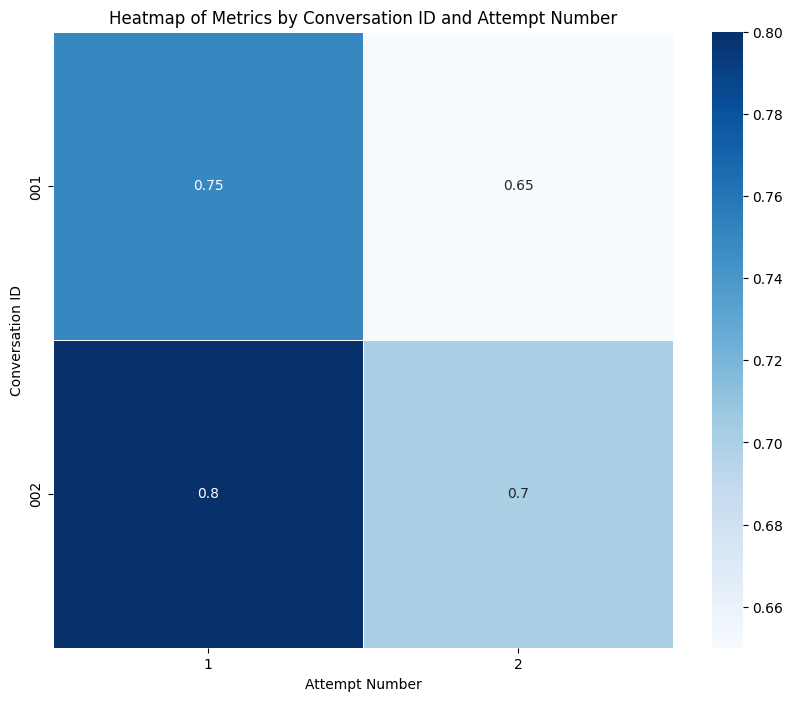

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data in the specified dictionary format
data = [
    {"conv_id": "001", "attempt_no": 1, "generated_response": "Hello", "target_response": "Hi", "metrics": 0.75},
    {"conv_id": "001", "attempt_no": 2, "generated_response": "How are you?", "target_response": "How's it going?", "metrics": 0.65},
    {"conv_id": "002", "attempt_no": 1, "generated_response": "I'm fine", "target_response": "I am good", "metrics": 0.80},
    {"conv_id": "002", "attempt_no": 2, "generated_response": "What's up?", "target_response": "What is happening?", "metrics": 0.70}
]

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame correctly using keyword arguments
heatmap_data = df.pivot(index="conv_id", columns="attempt_no", values="metrics")

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='Blues', linewidths=.5)

# Add labels and title if necessary
plt.title('Heatmap of Metrics by Conversation ID and Attempt Number')
plt.xlabel('Attempt Number')
plt.ylabel('Conversation ID')

# Show the plot
plt.show()


In [26]:
df

,conv_id,attempt_no,generated_response,target_response,metrics
0,001,1,Hello,Hi,0.75
1,001,2,How are you?,How's it going?,0.65
2,002,1,I'm fine,I am good,0.80
3,002,2,What's up?,What is happening?,0.70


In [42]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
sentence1 = "Hello"
sentence2 = "Hi"
model_name='all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
embeddings = model.encode([sentence1, sentence2])
cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])


In [44]:
embeddings[0].shape

(384,)

In [ ]:
def cosine_similarity_embeddings(sentence1, sentence2, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode([sentence1, sentence2])
    cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return cos_sim

In [85]:

dataset = load_dataset("bavard/personachat_truecased", "full")
cos_sim_list = []
for conv_id in range(0, 5):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)
    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]
    print (usr_response)
    cos_sim = cosine_similarity_embeddings(usr_response,history_convo[-1])
    cos_sim_list.append(cos_sim)


If I have time outside of hunting and remodeling homes. Which is not much!


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 44212.25 examples/s]


I'm also fascinated with mermaids.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 51856.29 examples/s]


Those are really yummy too, but not my favorite.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 58207.69 examples/s]


I doubt that very much. You probably like to scream alone.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 57068.30 examples/s]


That is awesome. Do you like it?


In [86]:
cos_sim_list

[0.14119357, 0.3144738, 0.427917, 0.27486795, 0.18668725]

In [75]:
### New metric to measure how likely the user is willing to start new topic
# start from 0 to indicate bot as first, start from 1 to indicate user as first
# 0 indicates how user 
cos_sim_list = []
for i in range(1,len(history_convo)-1,2):
    bot_uttr = history_convo[i]
    user_uttr =  history_convo[i+1]
    cos_sim = cosine_similarity_embeddings(bot_uttr, user_uttr)
    cos_sim_list.append(cos_sim)
    print(bot_uttr)
    print(user_uttr)
    

You must be very fast. Hunting is one of my favorite hobbies.
I am! For my hobby I like to do canning or some whittling.
I also remodel homes when I am not out bow hunting.
That's neat. When I was in high school I placed 6th in 100m dash!
That's awesome. Do you have a favorite season or time of year?
I do not. But I do have a favorite meat since that is all I eat exclusively.
What is your favorite meat to eat?
I would have to say its prime rib. Do you have any favorite foods?
I like chicken or macaroni and cheese.
Do you have anything planned for today? I think I am going to do some canning.
I am going to watch football. What are you canning?
I think I will can some jam. Do you also play footfall for fun?


In [74]:
# user's willingness 
cos_sim_list
avg_willingness = sum(cos_sim_list)/len(cos_sim_list)
print(avg_willingness)

0.42948577801386517


In [77]:
# bot's willingness
print(cos_sim_list)
avg_willingness = sum(cos_sim_list)/len(cos_sim_list)
print(avg_willingness)

[0.30346233, 0.018240921, 0.3325431, 0.73453104, 0.25507307, 0.23173182]
0.31259704753756523


In [78]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a sentence
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Example conversation
conversation = [
    "Let's talk about the recent advancements in AI.",
    "Sure, AI has made significant progress in various fields.",
    "What do you think about machine learning?",
    "Machine learning is a subset of AI that focuses on algorithms."
]

# Compute embeddings for each sentence
embeddings = [get_embedding(sentence) for sentence in conversation]

# Measure semantic similarity between consecutive sentences
similarities = [cosine_similarity(embeddings[i], embeddings[i+1])[0][0] for i in range(len(embeddings)-1)]

# Define a threshold to detect topic drift (e.g., similarity below 0.7 indicates drift)
threshold = 0.7
topic_drift_points = [i for i, similarity in enumerate(similarities) if similarity < threshold]

print("Topic drift detected at sentence indices:", topic_drift_points)

Topic drift detected at sentence indices: [1, 2]


In [79]:
similarities

[0.7349808, 0.6413611, 0.6749538]

### Cornel Movie Dialogs Corpus

In [3]:
from datasets import load_dataset

dataset = load_dataset("cornell-movie-dialog/cornell_movie_dialog")

Generating train split: 100%|██████████| 83097/83097 [1:08:03<00:00, 20.35 examples/s]


In [158]:
dataset['train'][4]

{'movieID': ' m0 ',
 'movieTitle': ' 10 things i hate about you ',
 'movieYear': ' 1999 ',
 'movieIMDBRating': ' 6.90 ',
 'movieNoIMDBVotes': ' 62847 ',
 'movieGenres': ['comedy', 'romance'],
 'characterID1': 'u0 ',
 'characterID2': ' u2 ',
 'characterName1': ' BIANCA ',
 'characterName2': ' CAMERON ',
 'utterance': {'text': ['L207 ', 'L208 '], 'LineID': ['L207', 'L208']}}

In [1]:
from convokit import Corpus, download

In [2]:
corpus = Corpus(filename=download("movie-corpus"))

In [43]:
num_of_utterances = 0
num_of_speakers = 0
conv_ids = []
conv_id = 0
 # only select conversation with 2 speakers and 12, 14, 16 utterances

while len(conv_ids) < 10:
    df = corpus.random_conversation().get_utterances_dataframe()
    num_of_utterances = df.shape[0]
    num_of_speakers = df['speaker'].nunique()
    conv_id = df['conversation_id'].iloc[0]
    #print("here")
    if ((num_of_utterances == 16 or num_of_utterances == 14 or num_of_utterances == 12) and (num_of_speakers == 2) and conv_id not in conv_ids):
        conv_ids.append(conv_id)
        print(conv_id)
        print(num_of_utterances)
    


print(df)

L637568
14
L552628
14
L406442
16
L221323
16
L357008
14
L396440
12
L267935
14
L484337
12
L147732
12
L356806
12
        timestamp                                   text speaker reply_to  \
id                                                                          
L356817      None  Zoe, come say hello to your father...   u6384  L356816   
L356816      None                                  Yeah.   u6378  L356815   
L356815      None           Do you want to talk to  Zoe?   u6384  L356814   
L356814      None                                  What?   u6378  L356813   
L356813      None                        Do you want to-   u6384  L356812   
L356812      None                               It's ok.   u6378  L356811   
L356811      None                  Fine. Is it going ok?   u6384  L356810   
L356810      None      I couldn't hear you. How are you?   u6378  L356809   
L356809      None                 It's Lydia, your wife.   u6384  L356808   
L356808      None                          

In [44]:

print(conv_ids)

['L637568', 'L552628', 'L406442', 'L221323', 'L357008', 'L396440', 'L267935', 'L484337', 'L147732', 'L356806']


In [45]:
import json

# Example list
my_list = conv_ids

# Specify the filename
filename = 'config.json'

# Read the existing JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)

# Update the content with the new list
config_data['conv_ids'] = my_list

# Save the updated content back to the JSON file
with open(filename, 'w') as file:
    json.dump(config_data, file, indent=4)

print(f"The list has been added to {filename}")

The list has been added to config.json


In [46]:
import json

# Specify the filename
filename = 'config.json'

# Load the updated content from the JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)

# Access the list
my_list = config_data['conv_ids']
# my_list = config_data.get('conv_ids', [])
print(f"The list loaded from {filename}: {my_list}")

The list loaded from config.json: ['L637568', 'L552628', 'L406442', 'L221323', 'L357008', 'L396440', 'L267935', 'L484337', 'L147732', 'L356806']


In [67]:
df = corpus.get_conversation(my_list[1]).get_utterances_dataframe()


In [68]:
# reverse the order
reversed_df = df.iloc[::-1]

In [75]:
len(reversed_df)

14

In [70]:
history_convo = reversed_df['text'].iloc[:-1].tolist()


In [74]:
len(history_convo)

13

In [72]:
history_convo_processed = "Dialogue history: \n"

for i in range(0,len(history_convo)-1,2):
    bot_uttr = "Bot: " + history_convo[i]
    user_uttr = "User: " + history_convo[i+1]
    full_uttr = bot_uttr + "\n" + user_uttr + "\n"
    history_convo_processed += full_uttr


In [76]:
#add the last utter from bot
history_convo_processed += "Bot: " + history_convo[-1] + "\n"
print(history_convo_processed)

Dialogue history: 
Bot: Do you have any witnesses, Major?
User: What?
Bot: What happened, Major?  Some kind of private beef between the two of you?
User: Look, I didn't shoot him!
Bot: We'll have to leave that up to the C.I.D. boys, won't we, Major?
User: Look, Colonel.  I've got to talk to somebody at Air Command.
Bot: Don't worry, Major.  Your rights will be fully protected.
User: Colonel, don't you know what's going on?
Bot: Sure I do.  There was some kind of mutiny on the base, and you killed General Ripper.
User: Look, General Ripper went off his rocker and ordered the 843rd Bomb Wing to attack with H-bombs.
Bot: You must think I'm an awful sap, Major.  Just sit down, fella, and keep your hands on the desk!
User: Didn't they tell you?
Bot: They told me, Major.  And I didn't hear anything about any atomic attack.



In [81]:
usr_response = reversed_df['text'].iloc[-1]

In [82]:
usr_response

"Look, Colonel.  You keep me covered, but let me just pick up this red telephone that connects to Air Command headquarters. Okay?...I won't play any tricks on you... Okay?"

In [ ]:
#preprocess the user response
usr_response_processed = "User: " + usr_response + "\n"

In [154]:
data = list(corpus.iter_speakers())

In [149]:
conv_id = data[6]
print(conv_id)
convo = corpus.get_conversation(conv_id)
convo.get_utterances_dataframe().head()

L860


,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L861,None,No...,u2,L860,L860,m0,"[{'rt': 0, 'toks': [{'tok': 'No', 'tag': 'UH',...",[]
L860,None,"Then Guillermo says, ""If you go any lighter, y...",u0,None,L860,m0,"[{'rt': 2, 'toks': [{'tok': 'Then', 'tag': 'RB...",[]


In [112]:
uttr = corpus.random_utterance()
convo = uttr.get_conversation()
spkr = uttr.speaker

In [79]:
convo = corpus.get_conversation('7yy032')

KeyError: '7yy032'

In [111]:
convo.get_utterances_dataframe()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L450786,None,What?,u7142,L450785,L450785,m479,"[{'rt': 0, 'toks': [{'tok': 'What', 'tag': 'WP...",[]
L450785,None,Housekeeping. I come to turn down the bed. 5...,u7138,None,L450785,m479,"[{'rt': 0, 'toks': [{'tok': 'Housekeeping', 't...",[]


In [88]:
spkr_convos = list(spkr.iter_conversations())
spkr_utts = list(spkr.iter_utterances())

In [91]:
convo.

ValueError: '<' not supported between instances of 'NoneType' and 'NoneType'
Utterance timestamps may not have been set correctly.

In [ ]:
def extract_format_data_movie(movie_df, conv_id, section='train'):
    dialog = dataset[section].filter(lambda example:example['conv_id']== conv_id)
    persona = dialog['personality'][-1]
    history_convo = dialog['history'][-1]
    usr_response = dialog['candidates'][-1][-1]

    unprocessed = [persona, history_convo, usr_response]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"
    
    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "User: " + usr_response + "\n"

    processed = [persona_processed, history_convo_processed, usr_response_processed]
    return unprocessed, processed

In [15]:
# List the first few utterances
for utt in corpus.utterances[:5]:
    print(utt.text)

# List the first few speakers
for spk in list(corpus.speakers.keys())[:5]:
    print(spk)

# List the first few conversations
for convo in list(corpus.conversations.keys())[:5]:
    print(convo)

TypeError: unhashable type: 'slice'

In [92]:
dataset2 = load_dataset("spawn99/CornellMovieDialogCorpus")

Generating movie_lines split: 100%|██████████| 304713/304713 [00:00<00:00, 1991915.74 examples/s]


In [104]:
dataset2

DatasetDict({
    movie_lines: Dataset({
        features: ['lineID', 'characterID', 'movieID', 'characterName', 'utterance'],
        num_rows: 304713
    })
})

In [108]:
dt = dataset2['movie_lines'].filter(lambda example:example['movieID']== "m0")

In [110]:
dt[1]

{'lineID': 'L1044',
 'characterID': 'u2',
 'movieID': 'm0',
 'characterName': 'CAMERON',
 'utterance': 'They do to!'}

In [1]:
from analyze import print_avg_metrics
print_avg_metrics("experiment1_metrics")

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


{'Conversation ID': 0, 'BLEU-1': 7.934612888501345, 'BLEU-2': 2.3656714136578905, 'BLEU-3': 1.3448370182769471, 'BLEU-4': 0.9347682646059561, 'ROUGE-1': 12.317371516387734, 'ROUGE-2': 1.5091142974381293, 'ROUGE-L': 9.986054508155949, 'Cosine Similarity': 19.568868968635798, 'Distinct-1': 90.73398072519451, 'Distinct-2': 98.83592592592592, 'Token Overlap Ratio': 6.785841634511783, 'Character Overlap Ratio': 51.82811138274294, 'Inter Similarity': 19.22069787650957, 'Persona Coverage': 3.4548921443495106, 'Persona Recall': 0.0, 'Persona Precision': 3.3430187212193525, 'Persona F1': 0.0}
